<a href="https://colab.research.google.com/github/ShabnaIlmi/Data-Science-Group-Project/blob/main/DSGP_UserData_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.ticker import LogLocator, FuncFormatter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the dataset with the proper delimiter (semicolon)
data = pd.read_excel('/content/drive/MyDrive/DSGP_User/Stock report 2.xlsx', sheet_name='Sheet1')

# Displaying the first few rows of the data
data.head()


,Warehouse,Product code,Invoice No,Transaction Date,UOM,Received Qty,Issued Qty,Customer name
0,B4,H2O2-50%-IG-ICL-BANGLADESH,SI-N/10/24/176,2024-10-10,KG,NaN,90,THARINDU WASHING PVT LTD
1,B4,H2O2-50%-IG-ICL-BANGLADESH,CB07/24/008,2024-10-11,KG,NaN,30,SACHITH FARM
2,B4,H2O2-50%-IG-ICL-BANGLADESH,SI-S/10/24/106,2024-10-11,KG,NaN,1800,OCEANPICK PVT LTD
3,B4,H2O2-50%-IG-ICL-BANGLADESH,SI-N/10/24/241,2024-10-15,KG,NaN,90,THARINDU WASHING PVT LTD
4,B4,H2O2-50%-IG-ICL-BANGLADESH,SI-N/10/24/263,2024-10-16,KG,NaN,120,COSAN LANKA (PVT) LTD


In [ ]:
# Displaying information
print("Displaying data information")
data.info()

Displaying data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Warehouse         14 non-null     object        
 1   Product code      14 non-null     object        
 2   Invoice No        14 non-null     object        
 3   Transaction Date  14 non-null     datetime64[ns]
 4   UOM               14 non-null     object        
 5   Received Qty      0 non-null      float64       
 6   Issued Qty        14 non-null     int64         
 7   Customer name     14 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 1.0+ KB


In [ ]:
# Identifying categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Displaying the categorical features
print("Categorical Features:")
print(categorical_cols)


Categorical Features:
Index(['Warehouse', 'Product code', 'Invoice No', 'UOM', 'Customer name'], dtype='object')


In [ ]:
# Displaying the unique values and their counts relevant to each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(data[col].value_counts(), "\n")


Column: Warehouse
Warehouse
B4    14
Name: count, dtype: int64 


Column: Product code
Product code
H2O2-50%-IG-ICL-BANGLADESH    14
Name: count, dtype: int64 


Column: Invoice No
Invoice No
SI-N/10/24/176    1
CB07/24/008       1
SI-S/10/24/106    1
SI-N/10/24/241    1
SI-N/10/24/263    1
SI-N/10/24/343    1
SI-N/10/24/370    1
SI-S/10/24/189    1
SI-N/10/24/460    1
SI-S/10/24/240    1
SI-N/10/24/489    1
SI-N/10/24/510    1
SI-N/10/24/527    1
SI-N/10/24/528    1
Name: count, dtype: int64 


Column: UOM
UOM
KG    14
Name: count, dtype: int64 


Column: Customer name
Customer name
THARINDU WASHING PVT LTD    4
OCEANPICK PVT LTD           3
COSAN LANKA (PVT) LTD       2
SACHITH  FARM               1
LITEOL DETERGENT            1
DAYANI WEAVING MILLS        1
MALEESHA INDUSTRIES         1
GLOW KEM LANKA              1
Name: count, dtype: int64 



In [ ]:
# Displaying the numerical features
print("Numerical Features:")
print(numerical_cols)

Numerical Features:
Index(['Received Qty', 'Issued Qty '], dtype='object')


In [ ]:
# Unique values and their counts relevant to each numerical columns
for col in numerical_cols:
    print(f"\nColumn: {col}")
    print(data[col].value_counts(), "\n")


Column: Received Qty
Series([], Name: count, dtype: int64) 


Column: Issued Qty 
Issued Qty 
90      4
1800    3
30      1
120     1
240     1
180     1
150     1
900     1
300     1
Name: count, dtype: int64 



In [ ]:
# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

# Convert 'Transaction Date' to datetime if not already done
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')

# Define thresholds
high_usage_limit = 500
unusual_transaction_limit = 5

# Define the current date (e.g., January 2025) and the 3-month cutoff
current_date = datetime(2024, 12, 1)
three_months_ago = current_date - timedelta(days=90)

# Filter data for the last 3 months
recent_data = data[data['Transaction Date'] >= three_months_ago]

# Group by customer and calculate total issued quantity and transaction count for the recent data
# For transaction_count, count the number of rows per customer
recent_customer_summary = recent_data.groupby('Customer name').agg(
    total_issued=('Issued Qty', 'sum'),
    transaction_count=('Customer name', 'count')  # Count occurrences of Customer name
).reset_index()

# Define risk level based on thresholds
def determine_risk(row):
    if row['total_issued'] > high_usage_limit or row['transaction_count'] > unusual_transaction_limit:
        return 'High Risk'  # High Risk
    elif row['total_issued'] > high_usage_limit * 0.75 or row['transaction_count'] > unusual_transaction_limit * 0.75:
        return 'Medium Risk'  # Medium Risk
    else:
        return 'Low Risk'  # Low Risk

# Apply the risk determination function to the recent customer summary
recent_customer_summary['Risk Level'] = recent_customer_summary.apply(determine_risk, axis=1)

# Drop existing 'Risk Level' column from the original data if it exists
if 'Risk Level' in data.columns:
    data.drop(columns=['Risk Level'], inplace=True)

# Merge back the risk levels to the original dataset (add "Low Risk" for customers with no recent activity)
data = data.merge(
    recent_customer_summary[['Customer name', 'Risk Level']],
    on='Customer name',
    how='left'
)

# Display the updated DataFrame with the new target variable
print(data[['Customer name', 'Issued Qty', 'Transaction Date', 'Risk Level']].head())

              Customer name  Issued Qty Transaction Date Risk Level
0  THARINDU WASHING PVT LTD          90       2024-10-10  High Risk
1             SACHITH  FARM          30       2024-10-11   Low Risk
2         OCEANPICK PVT LTD        1800       2024-10-11  High Risk
3  THARINDU WASHING PVT LTD          90       2024-10-15  High Risk
4     COSAN LANKA (PVT) LTD         120       2024-10-16   Low Risk


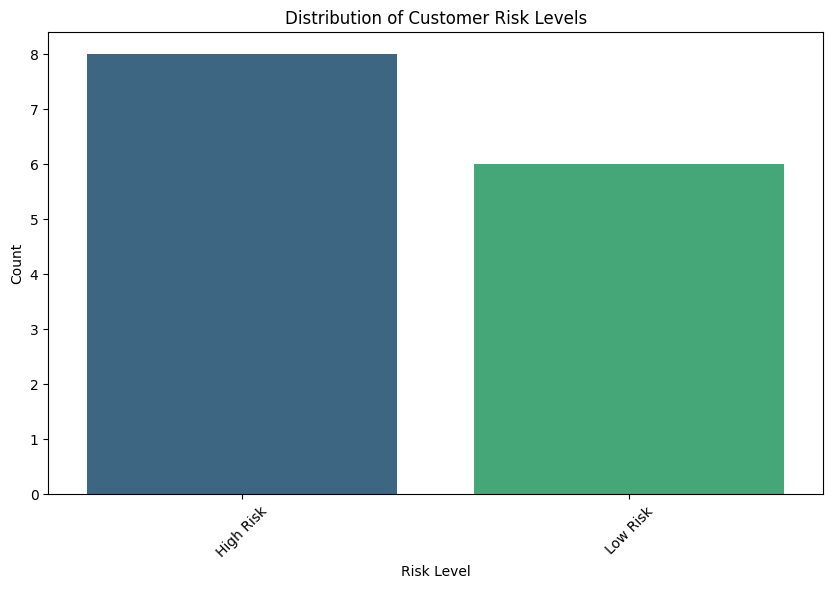

In [ ]:
# Visualizing the distribution of the target variable 'Risk Level'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Risk Level', palette='viridis')
plt.title('Distribution of Customer Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

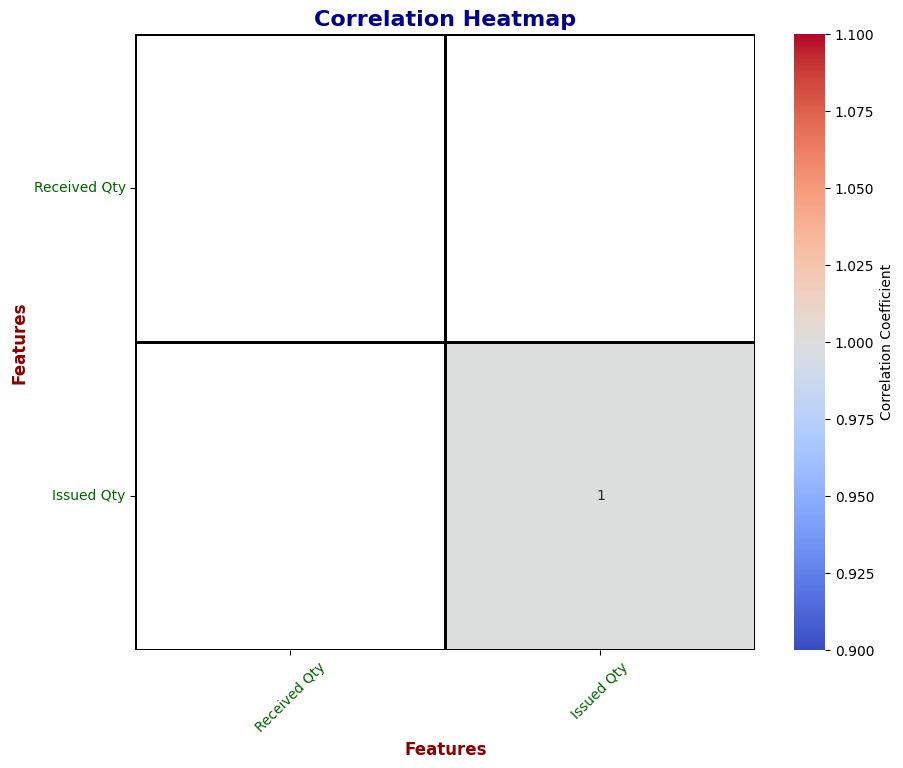

In [ ]:
# Visualizing the correlation heatmap for the numerical columns
plt.figure(figsize=(10, 8))

 # Update numerical_cols to reflect stripped column names
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# The Correlation Heatmap
sns.heatmap(
    data[numerical_cols].corr(),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'},
    linewidths=1,
    linecolor='black'
)

# Adding title and labels with formatting
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Features', fontsize=12, fontweight='bold', color='darkred')
plt.ylabel('Features', fontsize=12, fontweight='bold', color='darkred')

# Customizing tick labels for better readability
plt.xticks(fontsize=10, rotation=45, color='darkgreen')
plt.yticks(fontsize=10, rotation=0, color='darkgreen')

# Display the heatmap
plt.show()

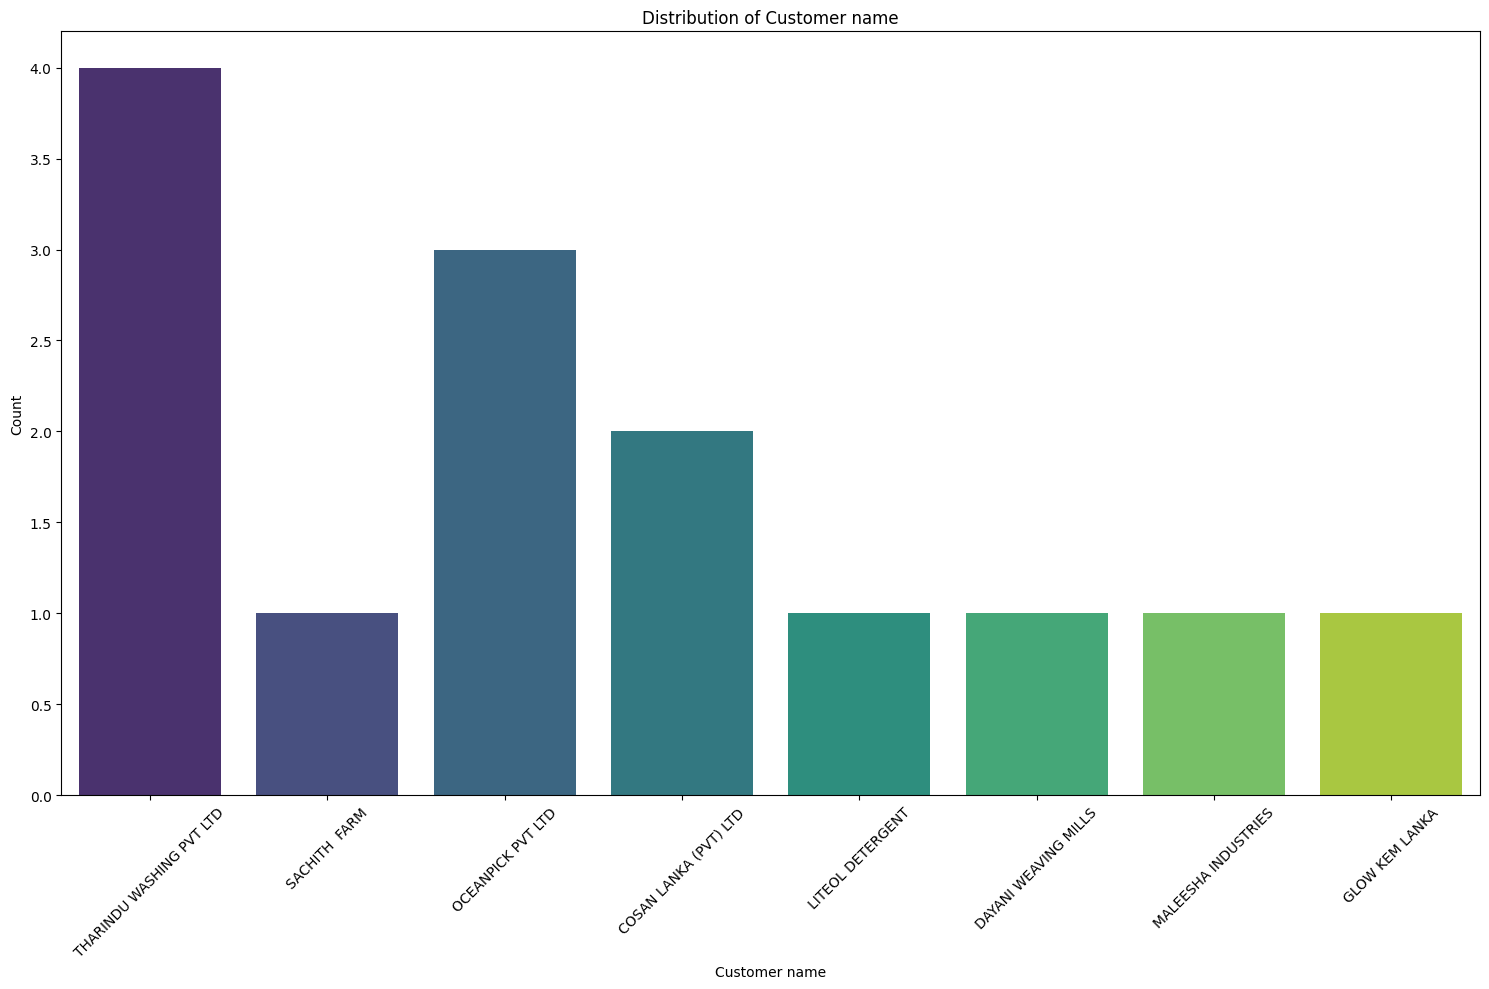

In [ ]:
# Defining a list to store the categorical variables
categorical_columns = [ 'Customer name']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through each categorical column and create a bar plot
for i, column in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 1, i + 1)  # Create a subplot for each column
    sns.countplot(data=data, x=column, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


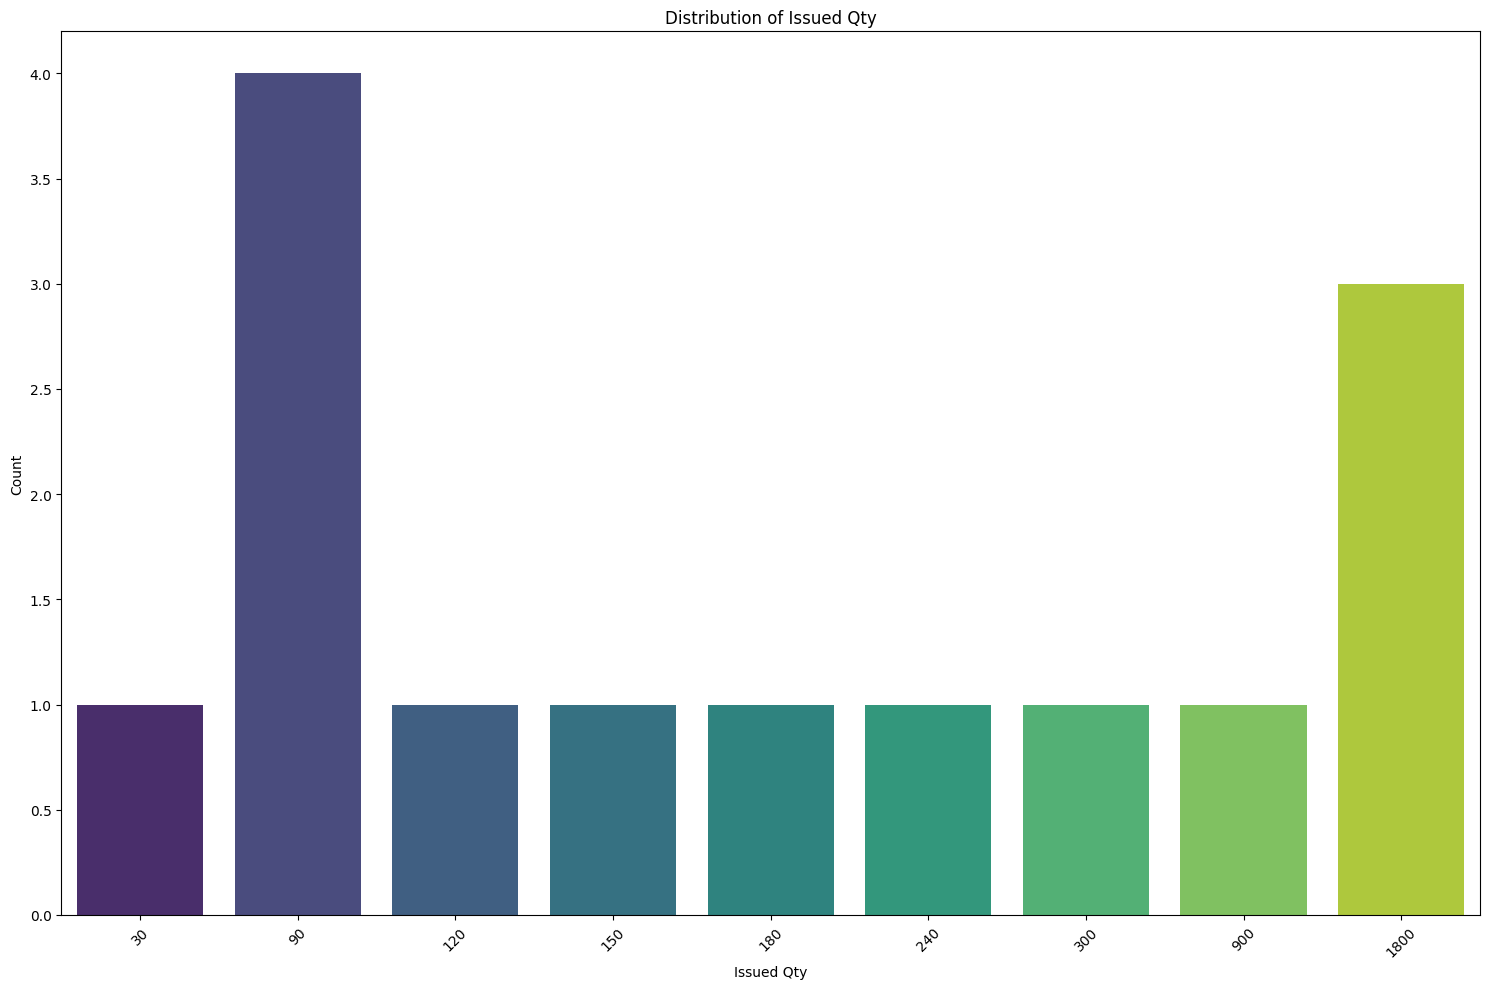

In [ ]:
# Defining a list to store the numerical variables
numerical_columns = [ 'Issued Qty'] # Remove trailing spaces

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through each categorical column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 1, i + 1)  # Create a subplot for each column
    sns.countplot(data=data, x=column, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

# Select numerical columns for outlier detection
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Function to detect outliers using the IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Check for outliers in each numerical column
outlier_summary = {}
for col in numerical_columns:
    outliers = detect_outliers_iqr(data, col)
    outlier_summary[col] = len(outliers)

# Display the number of outliers for each numerical column
outlier_summary_df = pd.DataFrame(outlier_summary.items(), columns=['Column', 'Number of Outliers'])
print(outlier_summary_df)

         Column  Number of Outliers
0  Received Qty                   0
1    Issued Qty                   3


#**Data Preprocessing**

---



In [ ]:
# Step 1: Removing whitespaces from the object type columns
object_columns = data.select_dtypes(include=['object']).columns
data[object_columns] = data[object_columns].apply(lambda x: x.str.strip())

# Step 2: Identifying and displaying duplicate values
print(f"Initial dataset shape: {data.shape}")

# Identify duplicates
duplicates = data[data.duplicated(keep=False)]  # Keep all duplicates for display
print(f"Number of duplicate rows found: {duplicates.shape[0]}")

# Remove duplicate values
data = data.drop_duplicates()
print(f"Shape after removing duplicates: {data.shape}")

Initial dataset shape: (14, 9)
Number of duplicate rows found: 0
Shape after removing duplicates: (14, 9)


In [ ]:
# Step 3: Handling missing values in the Categorical Columns

# Checking for missing values in the Categorical Columns
for column in categorical_cols:
    print(f"Missing values for column {column}: {data[column].isnull().sum()}")

Missing values for column Warehouse: 0
Missing values for column Product code: 0
Missing values for column Invoice No: 0
Missing values for column UOM: 0
Missing values for column Customer name: 0


In [ ]:
# Step 4: Handling missing values in the Numerical Columns

# Checking for missing values in the Numerical Columns
for column in numerical_cols:
    print(f"Missing values for column {column}: {data[column].isnull().sum()}")

Missing values for column Received Qty: 14
Missing values for column Issued Qty: 0


In [ ]:
# Drop the 'Received Qty' column
data = data.drop(columns=['Received Qty'])

# Display the updated DataFrame to confirm the column has been removed
print(data.head())

  Warehouse                Product code      Invoice No Transaction Date UOM  \
0        B4  H2O2-50%-IG-ICL-BANGLADESH  SI-N/10/24/176       2024-10-10  KG   
1        B4  H2O2-50%-IG-ICL-BANGLADESH     CB07/24/008       2024-10-11  KG   
2        B4  H2O2-50%-IG-ICL-BANGLADESH  SI-S/10/24/106       2024-10-11  KG   
3        B4  H2O2-50%-IG-ICL-BANGLADESH  SI-N/10/24/241       2024-10-15  KG   
4        B4  H2O2-50%-IG-ICL-BANGLADESH  SI-N/10/24/263       2024-10-16  KG   

   Issued Qty             Customer name Risk Level  
0          90  THARINDU WASHING PVT LTD  High Risk  
1          30             SACHITH  FARM   Low Risk  
2        1800         OCEANPICK PVT LTD  High Risk  
3          90  THARINDU WASHING PVT LTD  High Risk  
4         120     COSAN LANKA (PVT) LTD   Low Risk  


In [ ]:
# Select numerical columns for outlier detection
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Function to cap outliers using the IQR method
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply capping for outliers in each numerical column
for col in numerical_columns:
    data = cap_outliers_iqr(data, col)

# Display the updated DataFrame with capped outliers
print(data[numerical_columns].describe())

        Issued Qty
count    14.000000
mean    535.714286
std     686.414478
min      30.000000
25%      90.000000
50%     165.000000
75%     750.000000
max    1740.000000


In [ ]:
# All categorical columns are encoded using the label encoding since the categorical data contained within the dataset are ordinal

# Step 5: Encoding the categorical columns

# Defining the columns to be encoded
encoding_cols = ['Warehouse', 'Product code', 'Invoice No', 'UOM', 'Customer name', 'Risk Level']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in encoding_cols:
    data[column] = label_encoder.fit_transform(data[column])  # Convert to string to handle NaN values

# Display the first few rows of the updated DataFrame
data.head()

,Warehouse,Product code,Invoice No,Transaction Date,UOM,Issued Qty,Customer name,Risk Level
0,0,0,1,2024-10-10,0,90,7,0
1,0,0,0,2024-10-11,0,30,6,1
2,0,0,11,2024-10-11,0,1740,5,0
3,0,0,2,2024-10-15,0,90,7,0
4,0,0,3,2024-10-16,0,120,0,1


In [ ]:
# Redefine numerical_cols after dropping 'Received Qty'
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Step 5: Scaling the Numerical Features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_cols])

# Step 6: Handling the columns with low correlation coefficients with the target column
correlation_with_target = data.corr()['Risk Level'].sort_values(ascending=False)

# Print the correlation values
print("Correlation with Risk Level:")
print(correlation_with_target)

Correlation with Risk Level:
Risk Level          1.000000
Transaction Date    0.088220
Invoice No         -0.322252
Issued Qty         -0.524652
Customer name      -0.763321
Warehouse                NaN
Product code             NaN
UOM                      NaN
Name: Risk Level, dtype: float64


In [ ]:
# Dropping the columns with no correlation (Constant Columns)
columns_to_drop = ['Warehouse', 'Product code', 'UOM']
data = data.drop(columns=columns_to_drop)


In [ ]:
# Dropping the columns with low correlation
columns_to_drop = ['Invoice No', 'Issued Qty', 'Customer name']
data = data.drop(columns=columns_to_drop)

In [ ]:
# Dataset Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction Date  14 non-null     datetime64[ns]
 1   Risk Level        14 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 356.0 bytes


In [ ]:
# Step 7: Splitting Features and the Target Variable
X = data.drop(columns=['Risk Level'])
y = data['Risk Level']

# Step 8: Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Analyzing the distribution of the y train dataset
y_train.value_counts(normalize=True)

,proportion
Risk Level,
1,0.545455
0,0.454545


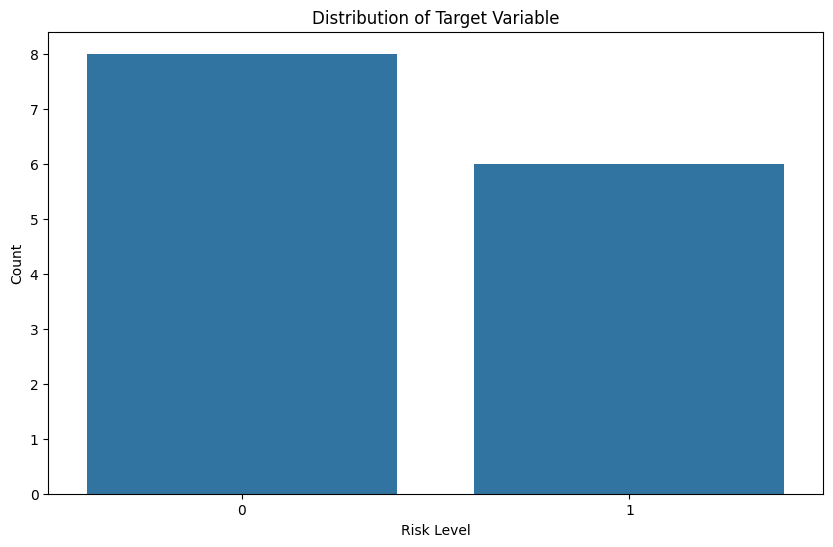

In [ ]:
# Visualizing the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Risk Level')
plt.xticks(rotation=0)
plt.title('Distribution of Target Variable')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

In [ ]:
# Displaying the dataset shape
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (11, 1)
Shape of X_test: (3, 1)
Shape of y_train: (11,)
Shape of y_test: (3,)


In [ ]:
# Step 1: Check for class imbalance in the 'Risk Level' column
class_distribution = data['Risk Level'].value_counts()

# Print the distribution of classes
print("Class distribution in 'Risk Level':")
print(class_distribution)


Class distribution in 'Risk Level':
Risk Level
0    8
1    6
Name: count, dtype: int64


Original dataset size: (14, 1)
Resampled dataset size: (16, 1)


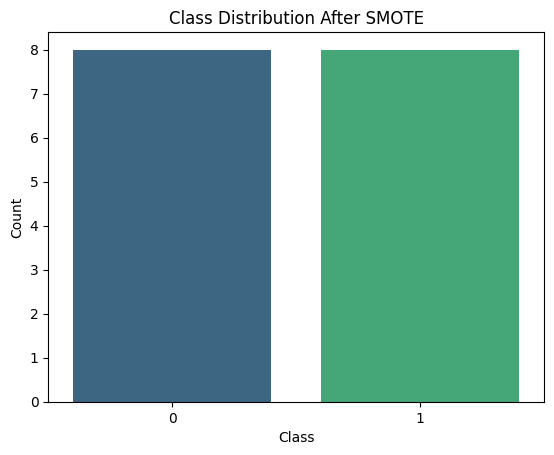

In [ ]:
# Suppressing the FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Handling imbalanced dataset
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original dataset size:", X.shape)
print("Resampled dataset size:", X_resampled.shape)

# Plotting class distribution after SMOTE
sns.countplot(x=y_resampled, palette="viridis")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
# Define the new folder path
folder_path = '/content/drive/MyDrive/DSGP_User/Pre Processed data'

# Define the file name for the saved dataset
file_name = 'preprocessed_stock_report 2.xlsx'

# Save the pre-processed DataFrame to the new folder
data.to_excel(os.path.join(folder_path, file_name), index=False)

print(f"Pre-processed dataset saved to: {os.path.join(folder_path, file_name)}")

Pre-processed dataset saved to: /content/drive/MyDrive/DSGP_User/Pre Processed data/preprocessed_stock_report 2.xlsx
